### LOW PRESSURE PORT CHECK

In [1]:
import sys,os,os.path

sys.path.append("../")   # cite IC from parent directory
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers
import iminuit,probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# all the efficiency functions

def cut_effic(df1, df2, verbose = False):
    '''
    Prints efficiency of cuts for singular cut
    df1 -> cut df
    df2 -> initial df
    '''
    length_1 = df1['event'].nunique()
    length_2 = df2['event'].nunique()
    efficiency = ((length_1/length_2)*100)
    print("Efficiency: {:.2f} %".format(efficiency))

    if (verbose == True):
        print(("Events in reduced dataframe: {}\nEvents in initial dataframe: {}").format(len(df1), len(df2)))

    return efficiency



def fiducial_track_cut_2(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    '''
    Produces fiducial track cuts while removing all events that have outer fiducial tracks
    '''
    # create lists of outer_fiduc entries
    z_df_low = df[(df['z_min'] <= lower_z)]
    z_df_up = df[(df['z_max'] >= upper_z)]
    r_df = df[(df['r_max'] >= r_lim)]

    # scrape the events
    low_list = (z_df_low['event'].to_numpy())
    up_list = (z_df_up['event'].to_numpy())
    r_list = (r_df['event'].to_numpy())

    # apply the filter to remove all events that fall in outer fiduc
    df1 = df[~df['event'].isin(low_list)]
    df2 = df1[~df1['event'].isin(up_list)]
    df3 = df2[~df2['event'].isin(r_list)]

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))


    return df3

def one_track_cuts(df, verbose = False):
    '''
    Remove events with more than one track
    THERE IS A COLUMN WITH THIS INFO IN IT, CALCULATING IT IS UNNECESSARY
    '''
    # 1-track event counter
    event_counts = df.groupby('event').size()
    #print(event_counts[:5]) # showing that you see how many 
                            #  trackIDs there are per event
    one_track = event_counts[event_counts == 1].index

    # filter dataframe
    one_track_events = df[df['event'].isin(one_track)]
    

    if (verbose == True):
        print("Removing events with more than one track.")
        print("Events with one track: {}".format(one_track))
        display(one_track_events.head())
    

    return one_track_events

def overlapping_cuts(df, verbose = False):
    '''
    Remove all events with energy overlap != 0
    '''

    ovlp_remove = df[df['ovlp_blob_energy']==0]

    if (verbose==True):
        print("Removing overlapping blobs...")

    return ovlp_remove

def energy_cuts(df, lower_e = 1.5, upper_e = 1.7, verbose = False):
    '''
    Apply cuts around the relevant energy
    '''
    filt_e_df = df[(df['energy'] >= lower_e) & (df['energy'] <= upper_e)]

    if (verbose == True):
        print("Cutting energy events around {} & {} keV".format(lower_e, upper_e))

    return filt_e_df

def len_events(df):
    '''
    Returns the number of unique events as len(df) doesn't work in this case
    '''
    length_1 = df['event'].nunique()
    return length_1


In [3]:
#adding here ROI
emin = 1.5
emax = 1.7

def plot_hist(df, column = 'energy', binning = 20, title = "Energy plot", output = True, fill = True, label = 'default', x_label = 'energy (MeV)', range = 0, data = False):
    '''
    Print a histogram of energy from our dataframe,.
    '''
    # for simplicity/readability, scoop out the relevant columns from the pandas dataframe.
    energy_vals = df[column].to_numpy()

    if (range==0):
        range = (np.min(energy_vals), np.max(energy_vals))

    # control viewing of hist
    if (fill == True):
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, range = range)
    else:
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, histtype='step', linewidth = 2, range = range)
    plt.title(title)
    plt.ylabel("events")
    plt.xlabel(x_label)
    if (output==True):
        plt.show()
    if (data==True):
        return (cnts, edges, patches)
    else:
        return

def load_data(folder_path):
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # NOTE Break this section up, its annoying like this.
    dfs = []
    df_trs = []
    df_ems = []
    i = 0
    end = len(file_names)
    # create massive dataframe with all of them
    for file in file_names:
        file_path = folder_path + file
        df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
        dfs.append(df)
        # include MC particles (boooo takes ages)

        # collecting the correct components of the file, not exactly sure how this works
        df_ps = pd.read_hdf(file_path, 'MC/particles')
        #df_ps = df_ps[df_ps.creator_proc == 'conv']
        # collecting event map
        df_em = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
        df_trs.append(df_ps)
        df_ems.append(df_em)
        i += 1

        if (i%1000 == 0):
            print(i)

    tracks = pd.concat(dfs, axis=0, ignore_index=True)

    particles = pd.concat(df_trs, ignore_index=True)
    eventmap = pd.concat([dt for dt in df_ems])
    # create particle list also

    return (tracks, particles, eventmap)

In [3]:
# load in all the data
folder_path = 'LPR/208Tl/PORT_1a/prod/isaura/isaura/'
port1_data = load_data(folder_path)

tracks = port1_data[0]
particles = port1_data[1]
eventmap = port1_data[2]

In [4]:
display(particles)
display(eventmap)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,2540000,1,Tl208,True,0,397.564026,392.015442,534.536865,0.000000,397.564026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,2540000,4,e-,False,1,397.564026,392.015442,534.536865,0.001609,407.646332,...,0.866701,-0.327340,0.002752,-0.000000,-0.000000,0.000000,0.547042,32.554752,RadioactiveDecay,eIoni
2,2540000,3,anti_nu_e,False,1,397.564026,392.015442,534.536865,0.001609,11181.164062,...,0.723798,-0.865316,0.547861,0.723798,-0.865316,0.547861,1.254116,18684.607422,RadioactiveDecay,Transportation
3,2540000,2,Pb208[3197.711],False,1,397.564026,392.015442,534.536865,0.001609,397.564026,...,-1.590499,1.192656,-0.550613,-0.000000,0.000000,-0.000000,0.000011,0.000000,RadioactiveDecay,RadioactiveDecay
4,2540000,6,gamma,False,2,397.564026,392.015442,534.536865,0.001609,164.141830,...,-0.455762,0.228695,0.282998,-0.000000,0.000000,-0.000000,0.583188,1501.569824,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8039692,2030356,91,e-,False,55,30.259228,426.134430,352.008423,2.193173,30.096209,...,-0.162406,0.015503,-0.008732,0.000000,0.000000,0.000000,0.025482,1.436975,eIoni,eIoni
8039693,2030356,90,e-,False,55,30.279558,429.029327,353.054474,2.120956,30.183689,...,0.064169,0.157650,0.102301,0.000000,-0.000000,-0.000000,0.037231,2.202024,eIoni,eIoni
8039694,2030356,89,e-,False,55,32.744003,438.281555,344.038391,1.840851,32.722652,...,-0.022657,0.085612,0.095038,0.000000,0.000000,-0.000000,0.016253,0.597368,eIoni,eIoni
8039695,2030356,88,e-,False,55,23.930265,443.683899,364.208191,1.648568,23.785473,...,-0.025266,-0.164843,-0.084782,-0.000000,0.000000,-0.000000,0.033170,1.671516,eIoni,eIoni


,evt_number
nexus_evt,
2540000,5080000
2540001,5080002
2540002,5080004
2540003,5080006
2540004,5080008
...,...
2030352,4060704
2030353,4060706
2030354,4060708


In [7]:
display(tracks)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.064387,81.777196,84,5940,2,381.675,159.675,334.439758,...,360.006691,397.858889,235.677770,373.233063,0.509660,0.023855,0.000000,9.166667,9.900000,4.865221
1,5080000,1,0.000118,0.000000,1,2,2,411.675,209.675,358.570496,...,358.570496,411.675000,210.180662,358.570496,0.000118,0.000118,0.000118,9.166667,9.900000,4.865221
2,5080002,0,1.071796,38.913376,33,3150,8,-75.325,363.675,631.573730,...,634.479397,-72.938238,388.111981,652.487580,0.770141,0.523741,0.222373,9.923077,9.416667,4.919173
3,5080002,1,0.713122,74.364693,67,2439,8,-91.325,423.675,607.419739,...,653.866115,-90.271181,430.961427,612.134018,0.353673,0.172315,0.000000,9.923077,9.416667,4.919173
4,5080002,2,0.164922,14.537515,8,456,8,133.675,362.675,499.294586,...,499.669457,150.614313,370.499348,503.501084,0.164922,0.164922,0.164922,9.923077,9.416667,4.919173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298743,4060710,0,0.572125,47.017825,42,4306,1,303.675,295.675,523.451904,...,525.243160,326.396140,342.064339,526.780906,0.295658,0.187772,0.000000,8.800000,8.666667,4.710175
298744,4060712,0,0.848074,41.455296,41,3373,4,20.675,416.675,335.498718,...,357.819710,29.325050,449.232398,336.989550,0.762644,0.125682,0.059711,9.166667,10.000000,4.836665
298745,4060712,1,0.021718,4.836665,2,86,4,22.675,457.675,394.266113,...,394.266113,23.738507,463.013650,399.784775,0.021718,0.021718,0.021718,9.166667,10.000000,4.836665
298746,4060712,2,0.019013,0.000000,1,55,4,22.675,472.675,419.465698,...,420.622514,24.155722,476.187137,420.622514,0.019013,0.019013,0.019013,9.166667,10.000000,4.836665


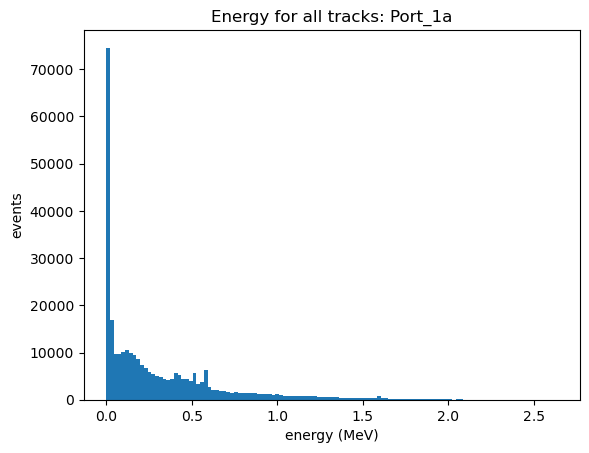

In [12]:
# collect the data
port_1a_hist = plot_hist(tracks, column = 'energy', binning = 120, title = "Energy for all tracks: Port_1a", data = True)
#print(port_1a_hist)

In [16]:
# now delete the previous data files, and do it for 1b, 2a, 2b
del(port1_data)
del(tracks)
del(eventmap)
del(particles)


NameError: name 'tracks' is not defined

### port 1b

In [18]:

#  load in all the data
folder_path = 'LPR/208Tl/PORT_1b/prod/isaura/isaura/'
port1_data = load_data(folder_path)

tracks = port1_data[0]
particles = port1_data[1]
eventmap = port1_data[2]

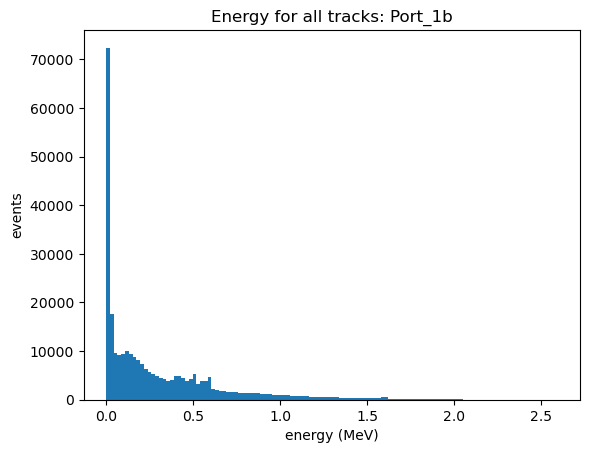

In [19]:
# collect the data
port_1b_hist = plot_hist(tracks, column = 'energy', binning = 120, title = "Energy for all tracks: Port_1b", data = True)
#print(port_1a_hist)

In [20]:
# now delete the previous data files, and do it for 1b, 2a, 2b
del(port1_data)
del(tracks)
del(eventmap)
del(particles)

# port 2a

In [21]:

#  load in all the data
folder_path = 'LPR/208Tl/PORT_2a/prod/isaura/isaura/'
port1_data = load_data(folder_path)

tracks = port1_data[0]
particles = port1_data[1]
eventmap = port1_data[2]

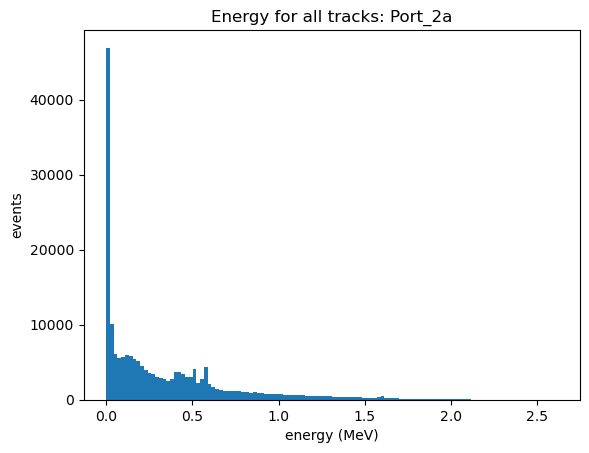

In [22]:
# collect the data
port_2a_hist = plot_hist(tracks, column = 'energy', binning = 120, title = "Energy for all tracks: Port_2a", data = True)
#print(port_1a_hist)

In [23]:
# now delete the previous data files, and do it for 1b, 2a, 2b
del(port1_data)
del(tracks)
del(eventmap)
del(particles)

# port 2b

In [24]:

#  load in all the data
folder_path = 'LPR/208Tl/PORT_2b/prod/isaura/isaura/'
port1_data = load_data(folder_path)

tracks = port1_data[0]
particles = port1_data[1]
eventmap = port1_data[2]

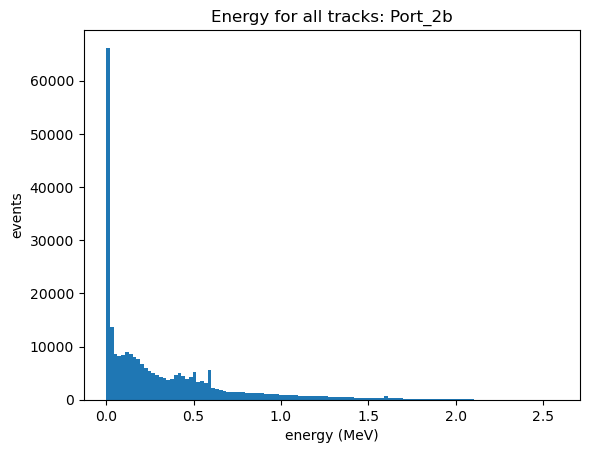

In [25]:
# collect the data
port_2b_hist = plot_hist(tracks, column = 'energy', binning = 120, title = "Energy for all tracks: Port_2b", data = True)
#print(port_1a_hist)

In [26]:
# now delete the previous data files, and do it for 1b, 2a, 2b
del(port1_data)
del(tracks)
del(eventmap)
del(particles)

In [33]:
 # save each ports histogram outputs
 np.save("analysis_data/port_1a_hist_cnt.npy", np.array(port_1a_hist[0]))
 np.save("analysis_data/port_1a_hist_edg.npy", np.array(port_1a_hist[1]))
 
 np.save("analysis_data/port_2a_hist_cnt.npy", np.array(port_2a_hist[0]))
 np.save("analysis_data/port_2a_hist_edg.npy", np.array(port_2a_hist[1]))

 np.save("analysis_data/port_1b_hist_cnt.npy", np.array(port_1b_hist[0]))
 np.save("analysis_data/port_1b_hist_edg.npy", np.array(port_1b_hist[1]))
 
 np.save("analysis_data/port_2a_hist_cnt.npy", np.array(port_2a_hist[0]))
 np.save("analysis_data/port_2a_hist_edg.npy", np.array(port_2a_hist[1]))
 

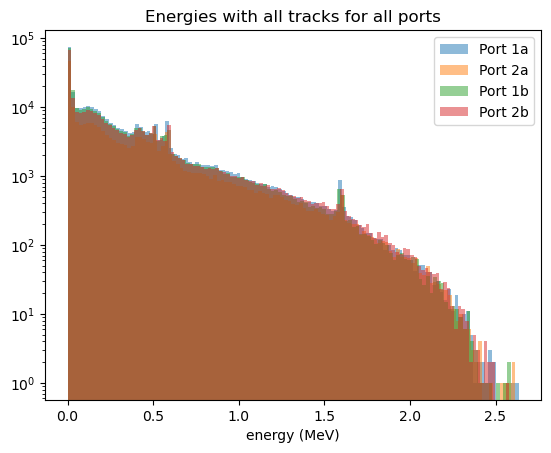

In [50]:
# plot them all on top of each other
p1a_centres = shift_to_bin_centers(port_1a_hist[1])
p1b_centres = shift_to_bin_centers(port_1b_hist[1])

p2a_centres = shift_to_bin_centers(port_2a_hist[1])
p2b_centres = shift_to_bin_centers(port_2b_hist[1])

p1a_bar_width = (port_1a_hist[1][1] - port_1a_hist[1][0])
p1b_bar_width = (port_1b_hist[1][1] - port_1b_hist[1][0])

p2a_bar_width = (port_2a_hist[1][1] - port_2a_hist[1][0])
p2b_bar_width = (port_2b_hist[1][1] - port_2b_hist[1][0])

plt.bar(p1a_centres, port_1a_hist[0], label = 'Port 1a', width = p1a_bar_width, fill = True, alpha = 0.5)
plt.bar(p2a_centres, port_2a_hist[0], label = 'Port 2a', width = p2a_bar_width, fill = True, alpha = 0.5)
plt.bar(p1b_centres, port_1b_hist[0], label = 'Port 1b', width = p1b_bar_width, fill = True, alpha = 0.5)
plt.bar(p2b_centres, port_2b_hist[0], label = 'Port 2b', width = p2b_bar_width, fill = True, alpha = 0.5)
plt.xlabel("energy (MeV)")
plt.yscale('log')
plt.legend()
plt.title("Energies with all tracks for all ports")
plt.show()

In [55]:
def plot_bar(centres, hist, widths, log = False, title = 'Default title', x_label = 'energy (MeV)'):

    plt.bar(centres, hist, label = 'Port 1a', width = widths, fill = True)
    if (log==True):
        plt.yscale('log')
    plt.title(title)
    plt.xlabel(x_label)
    plt.show()

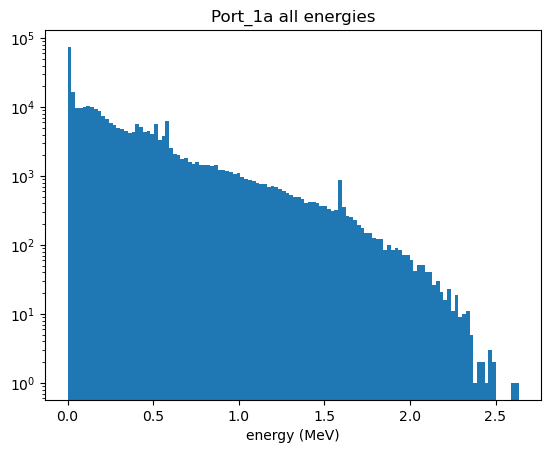

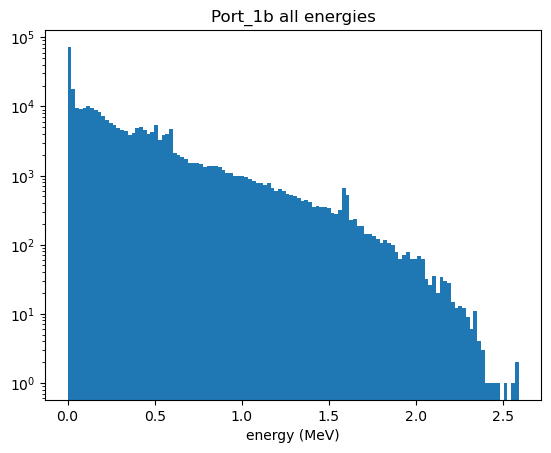

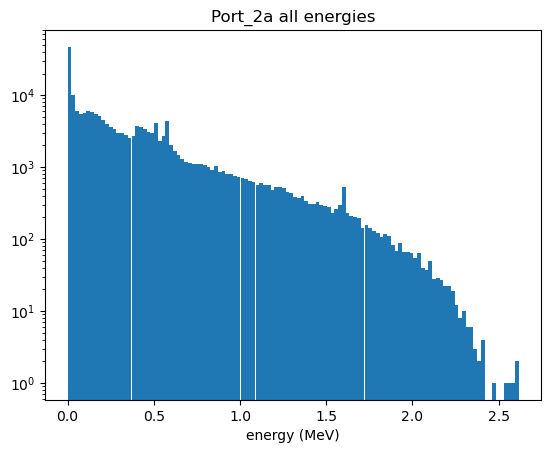

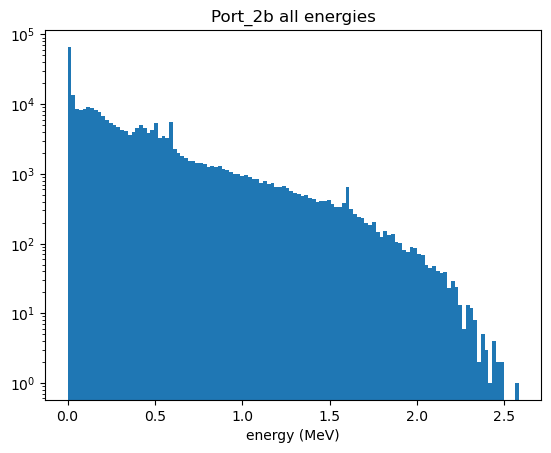

In [58]:
plot_bar(p1a_centres, port_1a_hist[0], p1a_bar_width, title = 'Port_1a all energies', log = True)
plot_bar(p1b_centres, port_1b_hist[0], p1b_bar_width, title = 'Port_1b all energies', log = True)
plot_bar(p2a_centres, port_2a_hist[0], p1b_bar_width, title = 'Port_2a all energies', log = True)
plot_bar(p2b_centres, port_2b_hist[0], p2b_bar_width, title = 'Port_2b all energies', log = True)

Processing: Port 1a
Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Efficiency: 70.28 %
Removing events with more than one track.
Events with one track: Int64Index([     14,      16,      22,      26,      32,      50,      52,
                 54,      58,      62,
            ...
            5980598, 5980608, 5980614, 5980618, 5980626, 5980634, 5980638,
            5980654, 5980658, 5980678],
           dtype='int64', name='event', length=20754)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
10,5080004,0,0.476680,33.258470,32,3334,1,14.675,-315.325,148.649429,...,154.872527,19.568310,-288.995425,154.235364,0.399762,0.270603,0.193685,9.200000,7.75,4.488581
44,5080022,0,0.419350,28.813773,26,2163,1,-151.325,66.675,739.729492,...,753.112228,-131.478871,67.453453,739.736348,0.406957,0.216779,0.204386,8.000000,10.00,4.369588
51,5080030,0,0.442330,41.407398,40,2829,1,-281.325,-181.325,691.413696,...,694.152331,-251.231056,-166.169291,713.223679,0.380825,0.102729,0.044644,8.833333,9.25,4.194712
52,5080032,0,1.577559,51.134095,75,6838,1,-204.325,-409.325,1140.831177,...,1146.240002,-172.539979,-368.168178,1150.723148,0.565083,0.361831,0.000000,9.714286,9.50,4.945103
86,5080048,0,0.399919,34.216900,28,3016,1,268.675,-24.325,250.468948,...,254.653853,272.209937,-2.318346,259.212131,0.313767,0.287219,0.201673,8.200000,9.80,3.462031


Single track cut
Relative Cut efficiency:
Efficiency: 29.54 %
Absolute Cut efficiency:
Efficiency: 25.93 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 31.88 %
Absolute Cut efficiency:
Efficiency: 6.62 %
Energy cut
Relative Cut efficiency:
Efficiency: 7.27 %
Absolute Cut efficiency:
Efficiency: 0.48 %
Port 1a


,Cut,Relative Efficiency,Single Cut Efficiency,Relative Events
0,No cuts,100.000000,100.000000,99977
1,Fiducial Cuts,70.281165,70.281165,70265
2,One track cut,29.536754,25.928964,20754
3,Blob overlap cuts,31.883011,6.618522,6617
4,Energy cuts,7.269155,0.481111,481


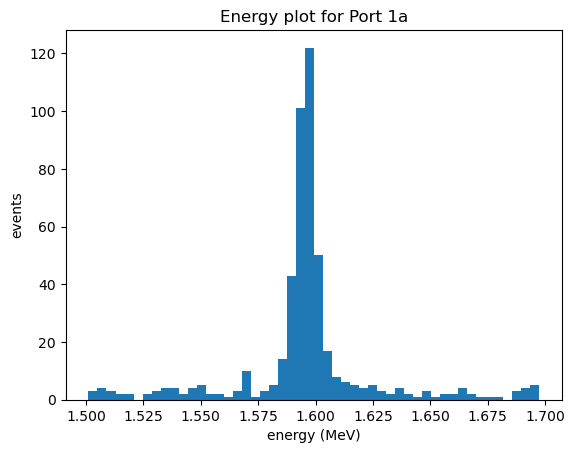

|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|

Processing: Port 1b
Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Efficiency: 68.76 %
Removing events with more than one track.
Events with one track: Int64Index([      2,      10,      16,      18,      20,      24,      38,
                 40,      68,      76,
            ...
            5980540, 5980548, 5980556, 5980566, 5980578, 5980580, 5980610,
            5980618, 5980620, 5980624],
           dtype='int64', name='event', length=18721)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
2,5080002,0,1.020287,138.697328,112,5238,1,108.675,130.675,272.493652,...,343.751501,108.945124,131.047965,284.011261,0.214749,0.079405,0.000000,9.800000,9.777778,4.825899
11,5080010,0,1.211451,107.531184,106,7024,1,346.675,-8.325,185.392624,...,188.276010,443.911190,-2.223853,202.768163,0.311175,0.174942,0.000000,9.333333,10.000000,4.819060
15,5080014,0,0.442679,29.589534,30,2747,1,-359.325,234.675,227.337357,...,240.183221,-331.491369,243.570298,234.536090,0.391155,0.384388,0.333912,8.500000,8.000000,4.716606
34,5080028,0,0.525087,58.507361,57,3807,1,-133.325,-415.325,706.148254,...,718.513895,-99.433448,-366.996231,723.941101,0.418857,0.054895,0.000000,9.400000,9.166667,4.607788
35,5080030,0,0.508468,25.155756,23,2941,1,-145.325,-297.325,789.099243,...,801.424997,-138.601214,-278.553774,796.682339,0.484367,0.460516,0.436416,9.250000,8.000000,4.186127


Single track cut
Relative Cut efficiency:
Efficiency: 28.50 %
Absolute Cut efficiency:
Efficiency: 24.83 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 34.64 %
Absolute Cut efficiency:
Efficiency: 6.79 %
Energy cut
Relative Cut efficiency:
Efficiency: 7.09 %
Absolute Cut efficiency:
Efficiency: 0.48 %
Port 1b


,Cut,Relative Efficiency,Single Cut Efficiency,Relative Events
0,No cuts,100.000000,100.000000,95524
1,Fiducial Cuts,68.755496,68.755496,65678
2,One track cut,28.504218,24.829362,18721
3,Blob overlap cuts,34.640244,6.788870,6485
4,Energy cuts,7.093292,0.481554,460


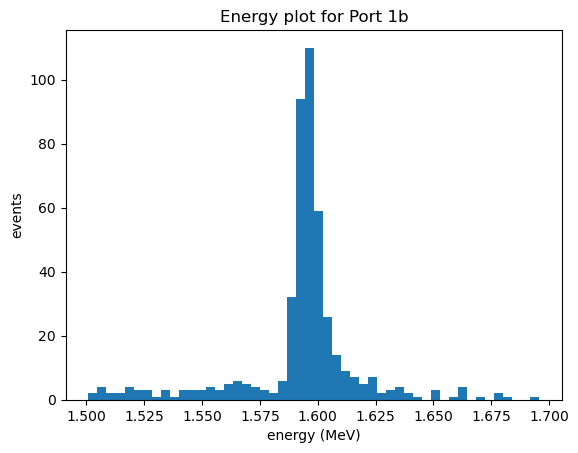

|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|

Processing: Port 2a
Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Efficiency: 72.06 %
Removing events with more than one track.
Events with one track: Int64Index([      0,       8,      24,      26,      34,      36,      46,
                 50,      62,      70,
            ...
            5980510, 5980528, 5980530, 5980542, 5980552, 5980560, 5980562,
            5980568, 5980570, 5980580],
           dtype='int64', name='event', length=21854)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,0.472159,31.471959,30,3162,1,-2.325,281.675,614.798340,...,621.274412,13.485816,284.842549,625.329295,0.389446,0.381647,0.298967,8.250000,9.142857,4.714096
5,5080006,0,0.612704,61.486358,41,2939,1,-47.325,-316.325,678.836975,...,683.411317,-44.994582,-266.668969,708.202637,0.369341,0.104306,0.000000,9.400000,9.714286,4.943734
26,5080020,0,0.553874,69.065699,60,3310,1,199.675,63.675,706.140564,...,737.597301,200.757943,83.876534,706.519941,0.343814,0.034670,0.000000,9.888889,8.250000,4.940665
39,5080028,0,0.602023,42.722694,36,2772,1,92.675,318.675,1139.764648,...,1158.486426,131.367147,327.662068,1142.225921,0.450596,0.144679,0.001809,8.800000,9.750000,4.715698
40,5080030,0,0.799050,66.926735,80,5436,1,-257.325,-315.325,399.546509,...,420.015467,-215.530841,-309.818439,415.306433,0.390580,0.242084,0.000000,9.428571,9.000000,4.705246


Single track cut
Relative Cut efficiency:
Efficiency: 31.80 %
Absolute Cut efficiency:
Efficiency: 28.51 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 26.39 %
Absolute Cut efficiency:
Efficiency: 6.05 %
Energy cut
Relative Cut efficiency:
Efficiency: 6.43 %
Absolute Cut efficiency:
Efficiency: 0.39 %
Port 2a


,Cut,Relative Efficiency,Single Cut Efficiency,Relative Events
0,No cuts,100.000000,100.000000,95368
1,Fiducial Cuts,72.060859,72.060859,68723
2,One track cut,31.800125,28.513757,21854
3,Blob overlap cuts,26.393338,6.048150,5768
4,Energy cuts,6.432039,0.389019,371


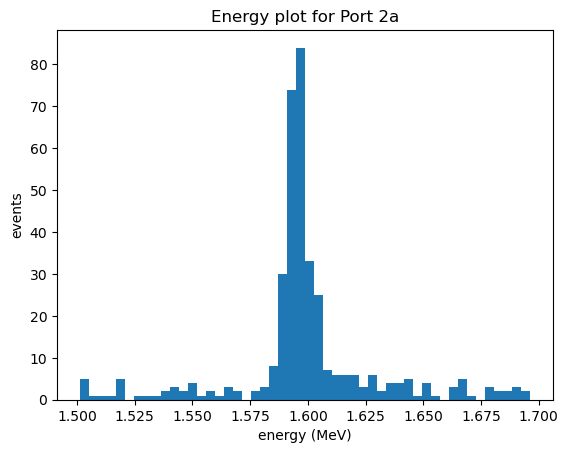

|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|

Processing: Port 2b
Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Efficiency: 72.06 %
Removing events with more than one track.
Events with one track: Int64Index([      0,       8,      24,      26,      34,      36,      46,
                 50,      62,      70,
            ...
            5980510, 5980528, 5980530, 5980542, 5980552, 5980560, 5980562,
            5980568, 5980570, 5980580],
           dtype='int64', name='event', length=21854)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,0.472159,31.471959,30,3162,1,-2.325,281.675,614.798340,...,621.274412,13.485816,284.842549,625.329295,0.389446,0.381647,0.298967,8.250000,9.142857,4.714096
5,5080006,0,0.612704,61.486358,41,2939,1,-47.325,-316.325,678.836975,...,683.411317,-44.994582,-266.668969,708.202637,0.369341,0.104306,0.000000,9.400000,9.714286,4.943734
26,5080020,0,0.553874,69.065699,60,3310,1,199.675,63.675,706.140564,...,737.597301,200.757943,83.876534,706.519941,0.343814,0.034670,0.000000,9.888889,8.250000,4.940665
39,5080028,0,0.602023,42.722694,36,2772,1,92.675,318.675,1139.764648,...,1158.486426,131.367147,327.662068,1142.225921,0.450596,0.144679,0.001809,8.800000,9.750000,4.715698
40,5080030,0,0.799050,66.926735,80,5436,1,-257.325,-315.325,399.546509,...,420.015467,-215.530841,-309.818439,415.306433,0.390580,0.242084,0.000000,9.428571,9.000000,4.705246


Single track cut
Relative Cut efficiency:
Efficiency: 31.80 %
Absolute Cut efficiency:
Efficiency: 28.51 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 26.39 %
Absolute Cut efficiency:
Efficiency: 6.05 %
Energy cut
Relative Cut efficiency:
Efficiency: 6.43 %
Absolute Cut efficiency:
Efficiency: 0.39 %
Port 2b


,Cut,Relative Efficiency,Single Cut Efficiency,Relative Events
0,No cuts,100.000000,100.000000,95368
1,Fiducial Cuts,72.060859,72.060859,68723
2,One track cut,31.800125,28.513757,21854
3,Blob overlap cuts,26.393338,6.048150,5768
4,Energy cuts,6.432039,0.389019,371


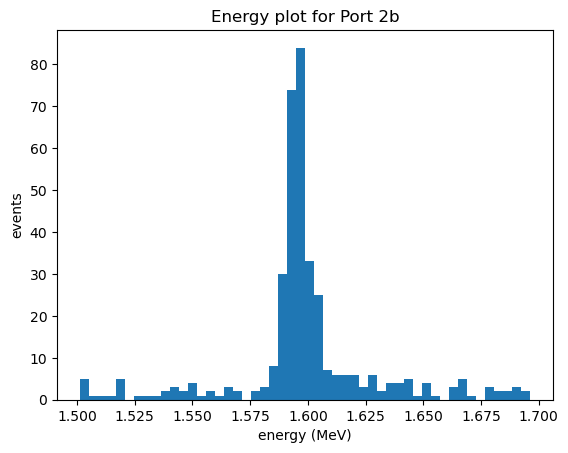

|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|



In [4]:
# then apply all the cuts to the data here
folder_path = ['LPR/208Tl/PORT_1a/prod/isaura/isaura/', 'LPR/208Tl/PORT_1b/prod/isaura/isaura/', 'LPR/208Tl/PORT_2b/prod/isaura/isaura/', 'LPR/208Tl/PORT_2b/prod/isaura/isaura/']
data_type = ['Port 1a', 'Port 1b', 'Port 2a', 'Port 2b']

# loop over and apply cuts
for i in range(len(data_type)):

    print('Processing: {}'.format(data_type[i]))
    port1_data = load_data(folder_path[i])

    tracks = port1_data[0]
    particles = port1_data[1]
    eventmap = port1_data[2]

        # for easy tracking
    cut_names = []
    rel_cut_effics = []
    abs_cut_effics = []
    cut_events = []

    # no cuts
    cut_names.append("No cuts")
    rel_cut_effics.append(100)
    abs_cut_effics.append(100)
    # number of events
    cut_events.append(len_events(tracks))

    cut_names.append("Fiducial Cuts")

    # make fiducial cuts
    fiducial = fiducial_track_cut_2(tracks, lower_z = 20, upper_z=1195, r_lim = 472, verbose = True)

    # make efficiency calculation
    ef = cut_effic(fiducial, tracks)

    # add efficiency calculation
    rel_cut_effics.append(ef)
    cut_events.append(len_events(fiducial))
    abs_cut_effics.append(ef)

        # relative

    cut_names.append("One track cut")
    one_track_rel = one_track_cuts(fiducial, verbose = True)

    # events are relative, as absolute efficiency lets you figure out events from the beginning# absolute
    one_track_abs = one_track_cuts(tracks)

    ## sanity check here
    #print(len_events(one_track_rel), len_events(one_track_abs), len_events(tracks))

    # relative
    print("Single track cut")
    print("================")
    print("Relative Cut efficiency:")
    ef = cut_effic(one_track_rel, fiducial)
    rel_cut_effics.append(ef)
    cut_events.append(len_events(one_track_rel))

    print("")
    # absolute
    print("Absolute Cut efficiency:")
    ef = cut_effic(one_track_abs, tracks)
    abs_cut_effics.append(ef)

    # apply cuts
    ovlp_rel = overlapping_cuts(one_track_rel)
    ovlp_abs = overlapping_cuts(tracks)
    print("")

    cut_names.append("Blob overlap cuts")


    # relative
    print("Blob overlap cut")
    print("================")
    print("Relative Cut efficiency:")
    ef = cut_effic(ovlp_rel, one_track_rel)
    rel_cut_effics.append(ef)
    cut_events.append(len_events(ovlp_rel))
    print("")

    # absolute
    print("Absolute Cut efficiency:")
    ef = cut_effic(ovlp_rel, tracks)
    abs_cut_effics.append(ef)

    ecut_rel = energy_cuts(ovlp_rel)
    ecut_abs = energy_cuts(tracks)
    print("")

    cut_names.append("Energy cuts")

    # relative
    print("Energy cut")
    print("================")
    print("Relative Cut efficiency:")
    ef = cut_effic(ecut_rel, ovlp_rel)
    rel_cut_effics.append(ef)
    cut_events.append(len_events(ecut_rel))
    print("")


    # absolute
    print("Absolute Cut efficiency:")
    ef = cut_effic(ecut_rel, tracks)
    abs_cut_effics.append(ef)

    efficiencies = pd.DataFrame({'Cut': cut_names,
                             'Relative Efficiency': rel_cut_effics,
                             'Single Cut Efficiency': abs_cut_effics,
                             'Relative Events': cut_events})

    print("{}".format(data_type[i]))
    display(efficiencies)

    # plot energy of final
    title_string = 'Energy plot for ' + str(data_type[i])
    plot_hist(ecut_rel, binning = 50, title = title_string)
    file_name_energy = 'analysis_data/' + str(data_type[i]).replace(" ", "_") + '_energy.npy'
    np.save(file_name_energy, ecut_rel['energy'].to_numpy())
    # delete the data on the way out for the next time :)
    # now delete the previous data files, and do it for 1b, 2a, 2b
    del(port1_data)
    del(tracks)
    del(eventmap)
    del(particles)

    # creating a gap
    print("|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n")